# Answering Business Questions using SQL

### Set up functions for accessing our 'Chinook' database

In [168]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Database file
database = "chinook.db"

In [3]:
# Function for connecting and querying to our db
# and store as a table
def run_query(query):
    with sqlite3.connect(database) as conn:
        return pd.read_sql(query, conn)

In [4]:
# Function for running sql commands
def run_command(cmd):
    with sqlite3.connect(database) as conn:
        conn.isolation_level = None
        conn.execute(cmd)

In [5]:
# Show tables
def show_tables():
    query = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view');"
    return run_query(query)

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Selecting the best Artists for Chinook Record Store

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

### Which genre sell the best in USA?

In [22]:
q_genre_sales_usa = '''
    WITH tracks_sold_usa AS 
    (
        SELECT il.*
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
        WHERE c.country = "USA"
    )
    
    SELECT 
        g.name genre,
        COUNT(tsu.invoice_line_id) tracks_sold,
        ROUND(CAST(COUNT(tsu.invoice_line_id) AS FLOAT) / (
            SELECT COUNT(*) FROM tracks_sold_usa
        ) * 100, 2) percentage_sold
    FROM tracks_sold_usa tsu
    INNER JOIN track t ON t.track_id = tsu.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY g.name
    ORDER BY tracks_sold DESC
'''
run_query(q_genre_sales_usa)

,genre,tracks_sold,percentage_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


In [28]:
genre_sales_usa = run_query(q_genre_sales_usa)
genre_sales_usa.set_index('genre', inplace=True, drop=True)
genre_sales_usa

,tracks_sold,percentage_sold
genre,,
Rock,561,53.38
Alternative & Punk,130,12.37
Metal,124,11.80
R&B/Soul,53,5.04
Blues,36,3.43
Alternative,35,3.33
Latin,22,2.09
Pop,22,2.09
Hip Hop/Rap,20,1.90


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



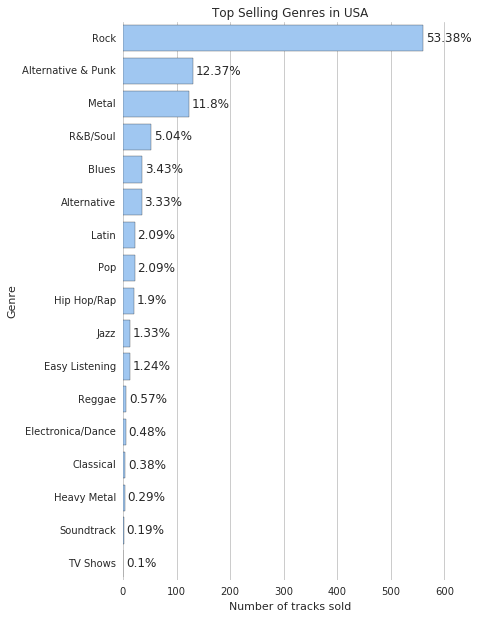

In [92]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6,10))

sns.set_color_codes("pastel")
sns.barplot(x=genre_sales_usa['tracks_sold'],
            y=genre_sales_usa.index, 
            color="b")

ax.set(xlim=(0, 625),
       ylabel="Genre",
       xlabel="Number of tracks sold",
       title="Top Selling Genres in USA")
sns.despine(left=True, bottom=True)

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"]
            ).astype(str) + "%"
    plt.annotate(str(label), (score + 5, i + 0.1))
    
plt.show()

From the results, Rock is the top selling genre in USA with TV shows as the least. TV Shows genre is probably a mislabeled outlier because it doesn't make any sense for the kinds of music genres.

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

In selecting 3 new artists for our record store, we can see that Red Tone (Punk), Meteor and the Girls (Pop), and Slim Jim Bites (Blues) get the first top matches in our data analysis; therefore, we will choose these 3 new artist for our record store. Moreover, we have to lookout for artists with Rock genre for they account for 53% of all sales.

### Employee Sales Performance
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [127]:
q_emp_total_sales = '''
    WITH customer_spent AS
    (
        SELECT 
            c.customer_id,
            c.support_rep_id,
            SUM(i.total) AS total_purchases
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        GROUP BY c.customer_id, c.support_rep_id
    )
    
    SELECT 
        e.first_name || " " || e.last_name AS employee_name,
        e.hire_date,
        SUM(cs.total_purchases) AS total_sales
    FROM customer_spent cs
    INNER JOIN employee e ON e.employee_id = cs.support_rep_id
    GROUP BY employee_name
    ORDER BY total_sales DESC
'''

run_query(q_emp_total_sales)

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


In [129]:
employee_sales = run_query(q_emp_total_sales)
employee_sales

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



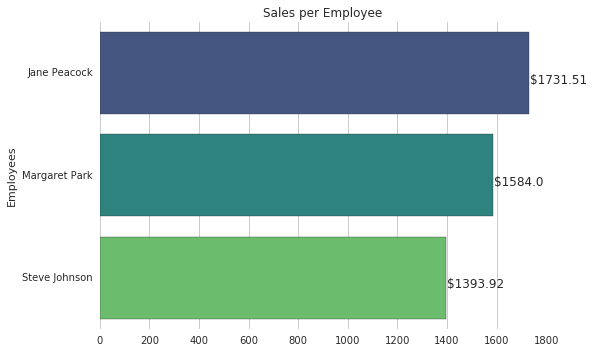

In [149]:
sns.barplot(
    x='total_sales',
    y='employee_name',
    data=employee_sales,
    palette="viridis")
sns.despine(left=True, bottom=True)

plt.xlabel('')
plt.ylabel('Employees')
plt.title("Sales per Employee")

for i, label in enumerate(list(employee_sales.index)):
    score = employee_sales.loc[label, "total_sales"]
    label = "$" + round((employee_sales.loc[label, "total_sales"]
            ).astype(float), 2).astype(str)
    plt.annotate(str(label), (score + 5, i + 0.1))

Jane Peacock is the top sales support agent but this is probably because she is hired the oldest among the others. Margaret Park was hired a month later than Jane with a difference of around 200 dollars in sales. Interestingly, Steve Johnson has a 5 months gap in terms of date hired with Margaret but managed to close the gap to less than 200 dollars difference. I would say Steve performs better than Margaret.

### Analyzing Sales per Country

In [165]:
q_country_sales = '''
    WITH country_or_other AS
    (
        SELECT
            CASE
               WHEN (
                     SELECT count(*)
                     FROM customer
                     where country = c.country
                    ) = 1 THEN "Other"
               ELSE c.country
            END AS country,
            c.customer_id,
            il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
    )
       
   SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
    FROM
        (
            SELECT
                country,
                COUNT(DISTINCT customer_id) customers,
                SUM(unit_price) total_sales,
                SUM(unit_price) / count(DISTINCT customer_id) customer_lifetime_value,
                SUM(unit_price) / count(DISTINCT invoice_id) average_order,
                CASE
                    WHEN country = "Other" THEN 1
                    ELSE 0
                END AS sort
            FROM country_or_other
            GROUP BY country
            ORDER BY sort ASC, total_sales DESC
        );
'''

run_query(q_country_sales)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


USA has the highest sales and the highest number of customers. On the other hand, if we total the sales of countries (Other) with just 1 customer, they amount the highest in sales. Surprisingly, there are 2 customers from Czech Republic that has multiple orders per transaction.

### Visualizing Sales per Country

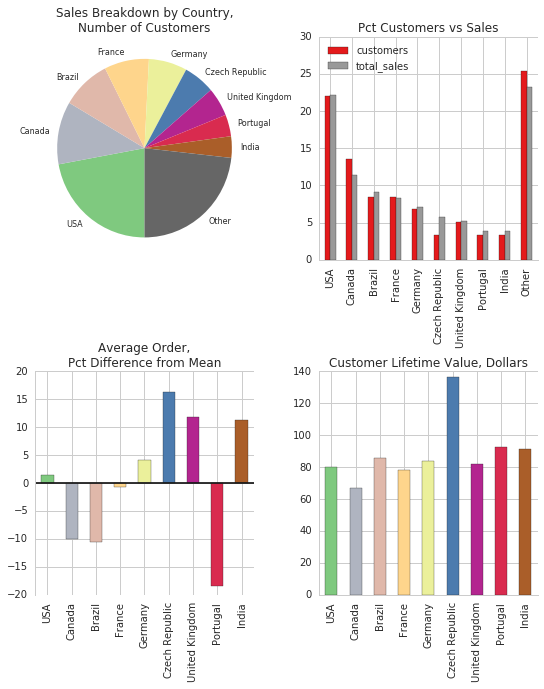

In [169]:
country_metrics = run_query(q_country_sales)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

### Albums vs Individual Tracks

In [170]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
         SELECT
             il.invoice_id invoice_id,
             MIN(il.track_id) first_track_id
         FROM invoice_line il
         GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) /
        (
            SELECT COUNT(*)
            FROM invoice
        ) AS percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                      SELECT t.track_id FROM track t
                      WHERE t.album_id = (
                                          SELECT t2.album_id FROM track t2
                                          WHERE t2.track_id = ifs.first_track_id
                                         ) 

                      EXCEPT 

                      SELECT il2.track_id FROM invoice_line il2
                      WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


There are more sales per individual tracks as compared to a whole album purchase.